# HVM Stress Relaxation

**Hybrid Vitrimer Model — Bi-exponential + permanent plateau**

## Physical Motivation

Stress relaxation reveals the **time-domain signature** of vitrimer dynamics: after
a step strain, the E-network stress decays as the natural state $\mu^E_{nat}$ drifts
to track $\mu^E$ via BER, while the D-network relaxes by conventional bond
dissociation. The P-network provides a permanent elastic plateau. This
bi-exponential + plateau structure is a direct spectral fingerprint of the
three-subnetwork architecture.

In experimental practice, stress relaxation is the primary test for:
- Extracting $G_P$ from the long-time residual modulus
- Verifying the factor-of-2: the E-network decays at rate $2k_{BER,0}$, not $k_{BER,0}$
- Distinguishing vitrimers from conventional thermosets (which show no relaxation) and thermoplastics (which relax fully to zero)

> **Handbook:** See [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) for the full step-strain derivation and ODE state evolution.

## Learning Objectives

- Simulate step-strain stress relaxation
- Observe bi-exponential decay from E and D networks
- Confirm $G(0^+) \approx G_{tot}$ and $G(\infty) \approx G_P$
- Compare constant-rate (analytical) vs TST (ODE) predictions

## Prerequisites

- **Notebook 01** (SAOS) — introduces the HVM architecture and parameter meanings

## Estimated Runtime

- ~1 min (ODE integration)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVMLocal

jax, jnp = safe_import_jax()
verify_float64()
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

After a step strain γ₀, the stress relaxes as:

$$G(t) = G_P + G_E \exp(-2 k_{BER,0} t) + G_D \exp(-k_d^D t)$$

**Key features:**
- $G(0^+) = G_P + G_E + G_D$ (total modulus)
- $G(\infty) = G_P$ (permanent network plateau)
- Two decay rates: E-network at $2k_{BER,0}$, D-network at $k_d^D$
- Factor-of-2 in E-network decay rate (vitrimer signature)

## 3. Relaxation Simulation

In [3]:
model = HVMLocal()
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-5)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

G_tot = model.G_P + model.G_E + model.G_D
tau_E = model.get_vitrimer_relaxation_time()
tau_D = 1.0 / model.k_d_D

print(f"G_tot = {G_tot:.0f} Pa")
print(f"G_P   = {model.G_P:.0f} Pa (long-time plateau)")
print(f"τ_E_eff = {tau_E:.4f} s")
print(f"τ_D     = {tau_D:.4f} s")

G_tot = 9000 Pa
G_P   = 5000 Pa (long-time plateau)
τ_E_eff = 43.4593 s
τ_D     = 0.1000 s


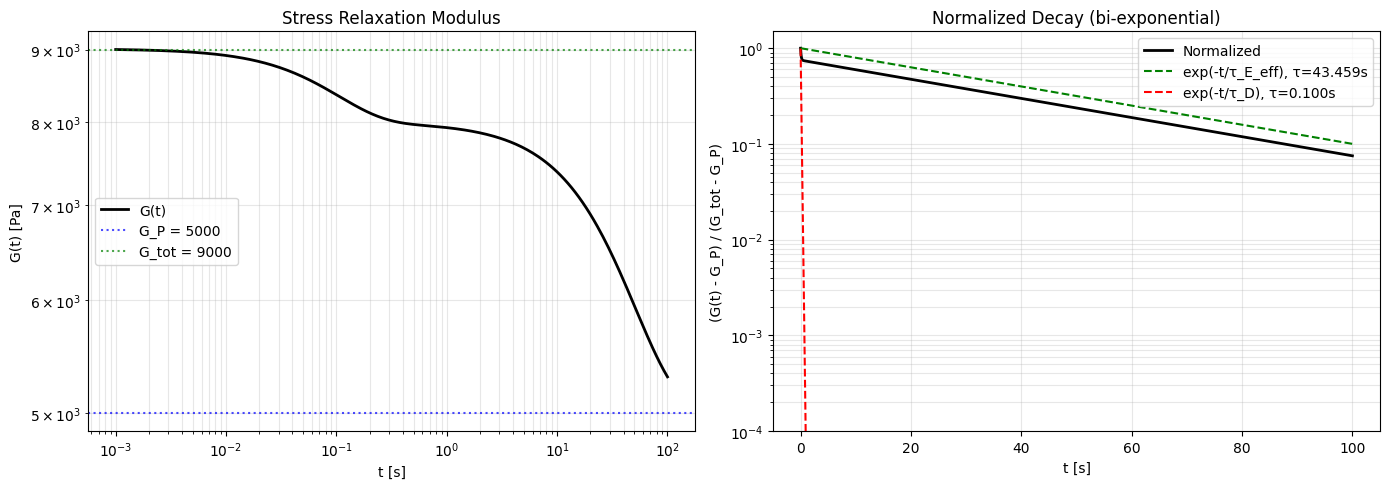

In [4]:
t = np.logspace(-3, 2, 300)
G_t = model.simulate_relaxation(t, gamma_step=0.01)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log plot
ax1.loglog(t, G_t, "k-", lw=2, label="G(t)")
ax1.axhline(model.G_P, color="blue", ls=":", alpha=0.7, label=f"G_P = {model.G_P:.0f}")
ax1.axhline(G_tot, color="green", ls=":", alpha=0.7, label=f"G_tot = {G_tot:.0f}")
ax1.set_xlabel("t [s]")
ax1.set_ylabel("G(t) [Pa]")
ax1.set_title("Stress Relaxation Modulus")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Normalized semi-log
ax2.semilogy(t, (np.array(G_t) - model.G_P) / (G_tot - model.G_P), "k-", lw=2, label="Normalized")
ax2.semilogy(t, np.exp(-t / tau_E), "g--", lw=1.5, label=f"exp(-t/τ_E_eff), τ={tau_E:.3f}s")
ax2.semilogy(t, np.exp(-t / tau_D), "r--", lw=1.5, label=f"exp(-t/τ_D), τ={tau_D:.3f}s")
ax2.set_xlabel("t [s]")
ax2.set_ylabel("(G(t) - G_P) / (G_tot - G_P)")
ax2.set_title("Normalized Decay (bi-exponential)")
ax2.legend()
ax2.set_ylim(1e-4, 1.5)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Full Trajectory Output

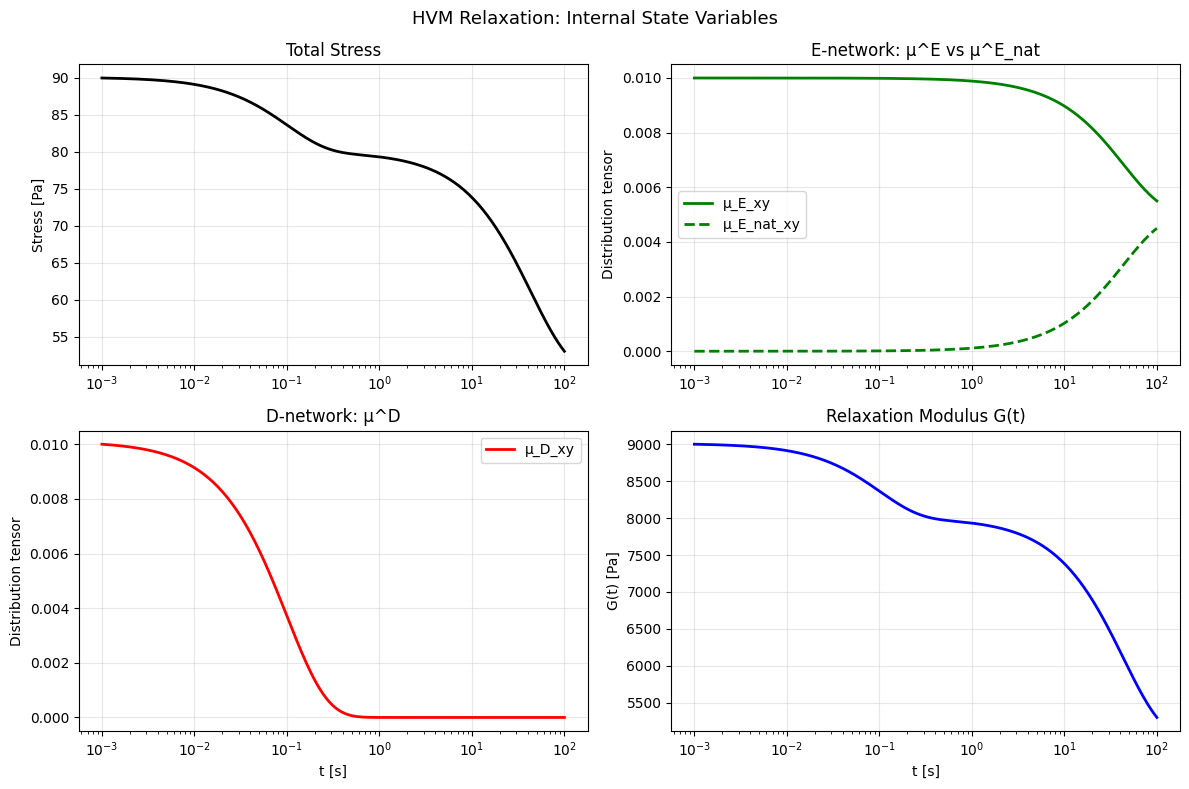

In [5]:
result = model.simulate_relaxation(t, gamma_step=0.01, return_full=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].semilogx(t, result["stress"], "k-", lw=2)
axes[0, 0].set_ylabel("Stress [Pa]")
axes[0, 0].set_title("Total Stress")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].semilogx(t, result["mu_E_xy"], "g-", lw=2, label="μ_E_xy")
axes[0, 1].semilogx(t, result["mu_E_nat_xy"], "g--", lw=2, label="μ_E_nat_xy")
axes[0, 1].set_ylabel("Distribution tensor")
axes[0, 1].set_title("E-network: μ^E vs μ^E_nat")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].semilogx(t, result["mu_D_xy"], "r-", lw=2, label="μ_D_xy")
axes[1, 0].set_ylabel("Distribution tensor")
axes[1, 0].set_xlabel("t [s]")
axes[1, 0].set_title("D-network: μ^D")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].semilogx(t, result["G_t"], "b-", lw=2)
axes[1, 1].set_ylabel("G(t) [Pa]")
axes[1, 1].set_xlabel("t [s]")
axes[1, 1].set_title("Relaxation Modulus G(t)")
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("HVM Relaxation: Internal State Variables", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Relaxation Spectrum

In [6]:
spectrum = model.get_relaxation_spectrum()
print("Discrete Relaxation Spectrum:")
print(f"{'Network':<12} {'G_i [Pa]':>10} {'τ_i [s]':>12}")
print("-" * 36)
for G_i, tau_i in spectrum:
    if np.isinf(tau_i):
        print(f"{'Permanent':<12} {G_i:>10.1f} {'∞':>12}")
    else:
        print(f"{'Transient':<12} {G_i:>10.1f} {tau_i:>12.4f}")

Discrete Relaxation Spectrum:
Network        G_i [Pa]      τ_i [s]
------------------------------------
Permanent        5000.0            ∞
Transient        3000.0      43.4593
Transient        1000.0       0.1000


## Key Takeaways

1. **Bi-exponential + plateau**: Two decay rates from E and D networks, plus $G_P$ plateau
2. **$G(0^+) \approx G_{tot}$**: All networks contribute at short times
3. **$G(\infty) = G_P$**: Only the permanent network survives at long times
4. **Natural state tracking**: $\mu^E_{nat}$ drifts toward $\mu^E$, erasing E-network stress
5. **Factor-of-2 confirmed**: The E-network decays at rate $2k_{BER,0}$ in the normalized plot

## Further Reading

- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Constitutive equations and factor-of-2 derivation
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — Multi-protocol fitting strategy (relaxation is step 2)

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.
2. Meng, F., Saed, M.O. & Terentjev, E.M. (2019). *Macromolecules*, 52(19), 7423-7429.

## Next Notebooks

- **Notebook 03**: Startup shear — TST stress overshoot
- **Notebook 04**: Creep — vitrimer plastic flow